# (10) vH16 — tst

**Motivation**: host = ```any```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

In [3]:
model_name = 'poisson_vH16_t-64_z-[512]_<jacob|lin>'
fit_name = 'u:(8.0)-du:(7.0)_b200-ep300-lr(0.002)_beta(32:0x0.1)_temp(0.05:lin-0.5)_gr(500)_(2024_09_12,20:23)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

300

In [4]:
tr.n_iters, tr.model.cfg.clamp_u, tr.model.cfg.clamp_du

(154500, 8.0, 7.0)

In [5]:
print(tr.model.layer.n_exp)

tensor([ 25,  34,  45,  60,  78,  96, 114, 129, 140, 147, 152, 154, 156, 156,
        156, 156, 156, 156, 155, 155, 155, 155, 154, 154, 154, 153, 153, 153,
        153, 153, 153, 153, 153, 153, 152, 152, 152, 152, 152, 152, 152, 152,
        152, 152, 152, 152, 152, 151, 151, 151, 152, 151, 151, 152, 151, 151,
        151, 151, 151, 151, 151, 151, 151, 151], device='cuda:0',
       dtype=torch.int32)

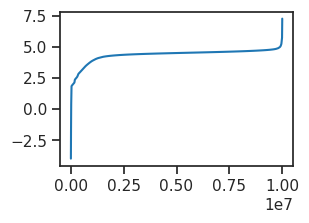

In [6]:
plt.plot(sorted(tr.model.stats['u_max']))

In [7]:
u_max = np.array(tr.model.stats['u_max'])
du_max = np.array(tr.model.stats['du_max'])

u_max.max(), du_max.max()

(7.269288539886475, 2.424907684326172)

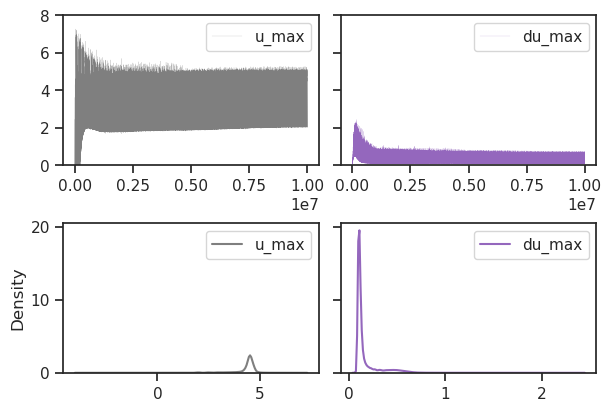

In [8]:
fig, axes = create_figure(2, 2, sharey='row')

axes[0, 0].plot(u_max, color='C7', lw=0.1, label='u_max')
axes[0, 1].plot(du_max, color='C4', lw=0.1, label='du_max')
axes[0, 1].set(ylim=(0, 8))

sns.kdeplot(u_max, color='C7', label='u_max', ax=axes[1, 0])
sns.kdeplot(du_max, color='C4', label='du_max', ax=axes[1, 1])

add_legend(axes)
plt.show()

In [12]:
grad = np.array(list(tr.stats['grad'].values()))
(grad > tr.cfg.grad_clip).sum(), np.round((grad > tr.cfg.grad_clip).mean(), 3)

(0, 0.0)

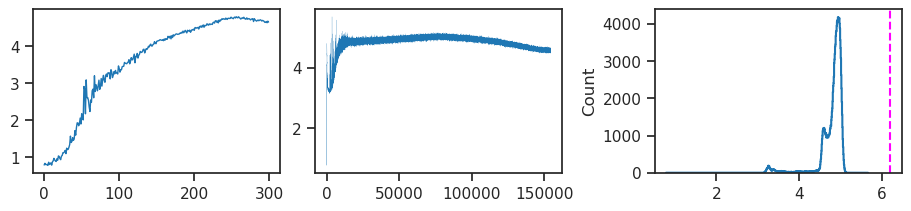

In [13]:
fig, axes = create_figure(1, 3)

axes[0].plot(np.log(grad)[:300], lw=1)
axes[1].plot(np.log(grad), lw=0.1)

axes[2].axvline(np.log(tr.cfg.grad_clip), color='magenta', ls='--')
histplot(np.log(grad), ax=axes[2])

plt.show()

100%|███████████████████████████████████| 2/2 [00:53<00:00, 26.58s/it]


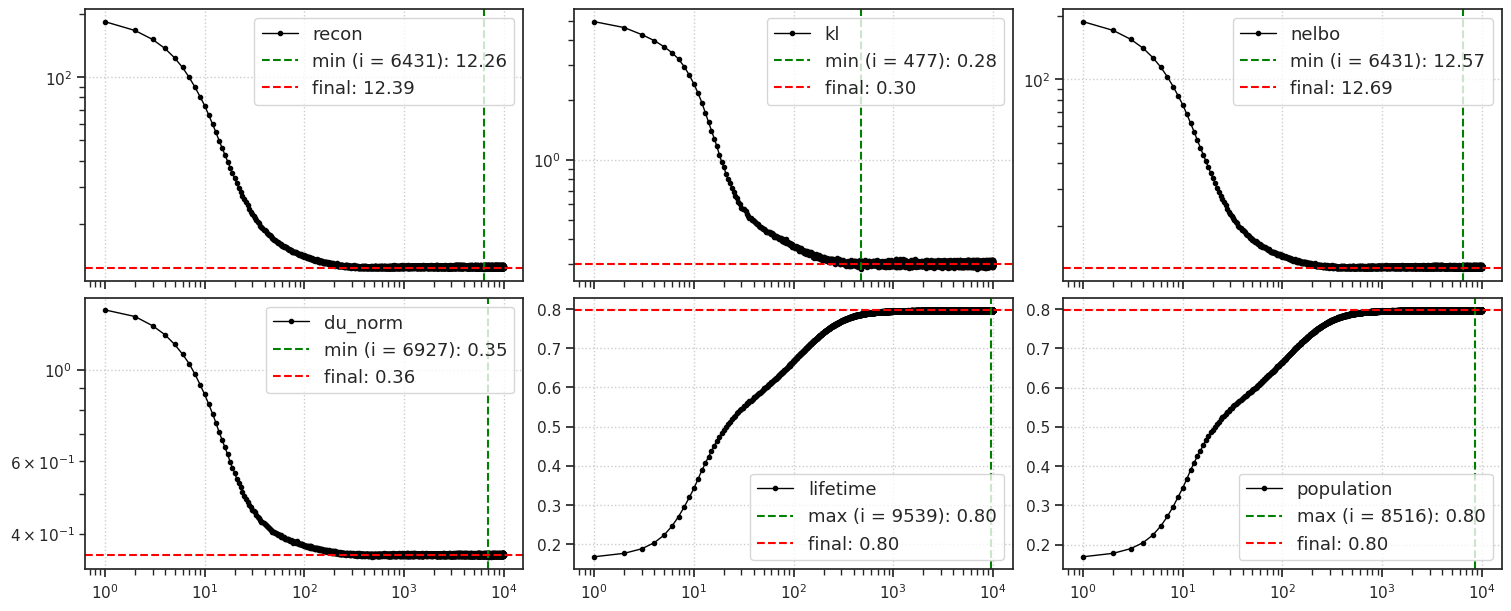

In [14]:
kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=2,
)
results = tr.analysis('vld', **kws)
_ = plot_convergence(results, color='k')

In [34]:
x = next(iter(tr.dl_vld))[0]

In [59]:
ff = []
for i in tqdm(range(100)):
    output = tr.model.xtract_ftr(
        x=x,
        seq=range(1000),
        return_extras=True,
    ).stack()
    ff.append(tonp(output['ff']))
ff = np.stack(ff)

100%|█████████████████████████████████████████| 100/100 [04:02<00:00,  2.42s/it]


In [60]:
ff.shape

(100, 200, 1000, 512)

In [63]:
du_expect = ff.mean(0)
du_expect_norm = np.linalg.norm(du_expect, axis=-1)
du_expect_norm_avg = du_expect_norm.mean(0)

du_expect_norm.shape

(200, 1000)

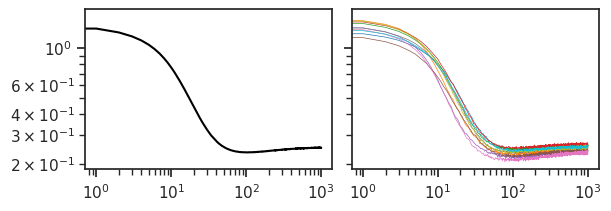

In [64]:
fig, axes = create_figure(1, 2, sharey='row')
axes[0].loglog(du_expect_norm_avg, color='k')
axes[1].loglog(du_expect_norm[:10].T, lw=0.5);

In [65]:
du_expect_norm_avg[-1]

0.2502581

<Axes: ylabel='Count'>

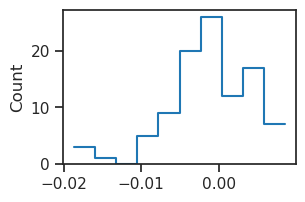

In [70]:
sample_i = 123
latent_i = 401
t = -1

histplot(ff[:, sample_i, t, latent_i])

In [71]:
ff[:, sample_i, t, latent_i].mean()

-0.0011150932

In [72]:
du_expect.shape

(200, 1000, 512)

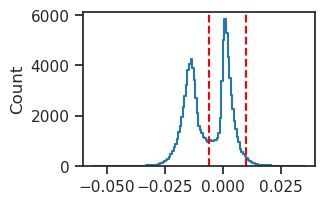

In [86]:
ax = histplot(du_expect[:, t, :].ravel())
ax.axvline(-0.006, color='r', ls='--')
ax.axvline(0.01, color='r', ls='--')

In [24]:
kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=1,
)
results = {}
for i in range(13):
    results[i] = tr.analysis('vld', **kws)

100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


In [25]:
results[4]['du_norm'].shape

(1000,)

In [27]:
{k: v.shape for k, v in results[4].items() if '_final' not in k}

{'kl': (1000,),
 'recon': (1000,),
 'nelbo': (1000,),
 'du_norm': (1000,),
 'lifetime': (1000,),
 'population': (1000,)}

In [29]:
results_trial = collections.defaultdict(list)
for d in results.values():
    for k, v in d.items():
        results_trial[k].append(v)
results_trial = {
    k: np.stack(v) for k, v
    in results_trial.items()
}

In [33]:
{k: v.shape for k, v in results_trial.items()}

{'kl': (13, 1000),
 'recon': (13, 1000),
 'nelbo': (13, 1000),
 'du_norm': (13, 1000),
 'lifetime': (13, 1000),
 'population': (13, 1000),
 'state_final': (13, 200, 512),
 'samples_final': (13, 200, 512)}

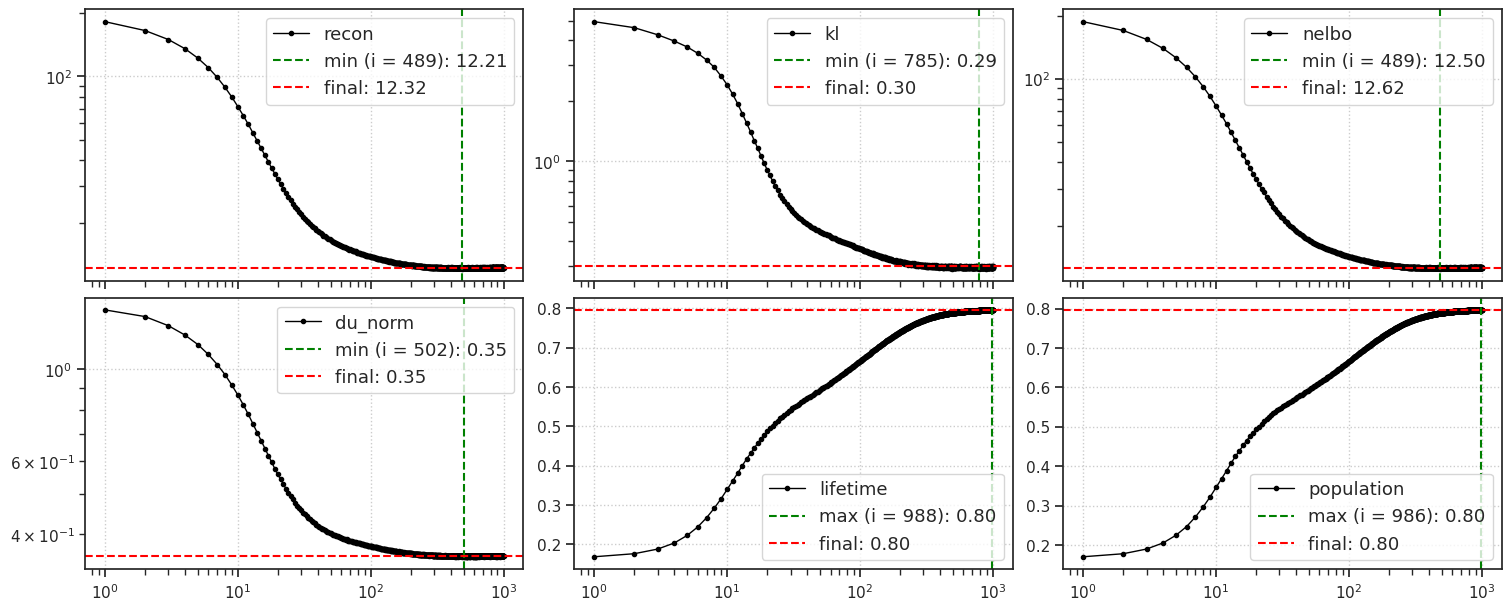

In [32]:
_ = plot_convergence({k: v.mean(0) for k, v in results_trial.items()}, color='k')

### Generate

In [15]:
n_samples = 128
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)
pred = tr.model.pred

In [16]:
n_iters = 200
output = tr.model.generate(pred, seq=range(n_iters))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['loss_kl', 'loss_recon', 'dist', 'ff', 'recon', 'state', 'samples']

In [17]:
shape = (n_samples, *tr.model.cfg.input_sz[1:])
pred = pred.reshape(shape)

shape_y = (n_samples, n_iters, *tr.model.cfg.input_sz[1:])
y = output['recon'].reshape(shape_y)

pred.shape, y.shape

(torch.Size([128, 16, 16]), torch.Size([128, 200, 16, 16]))

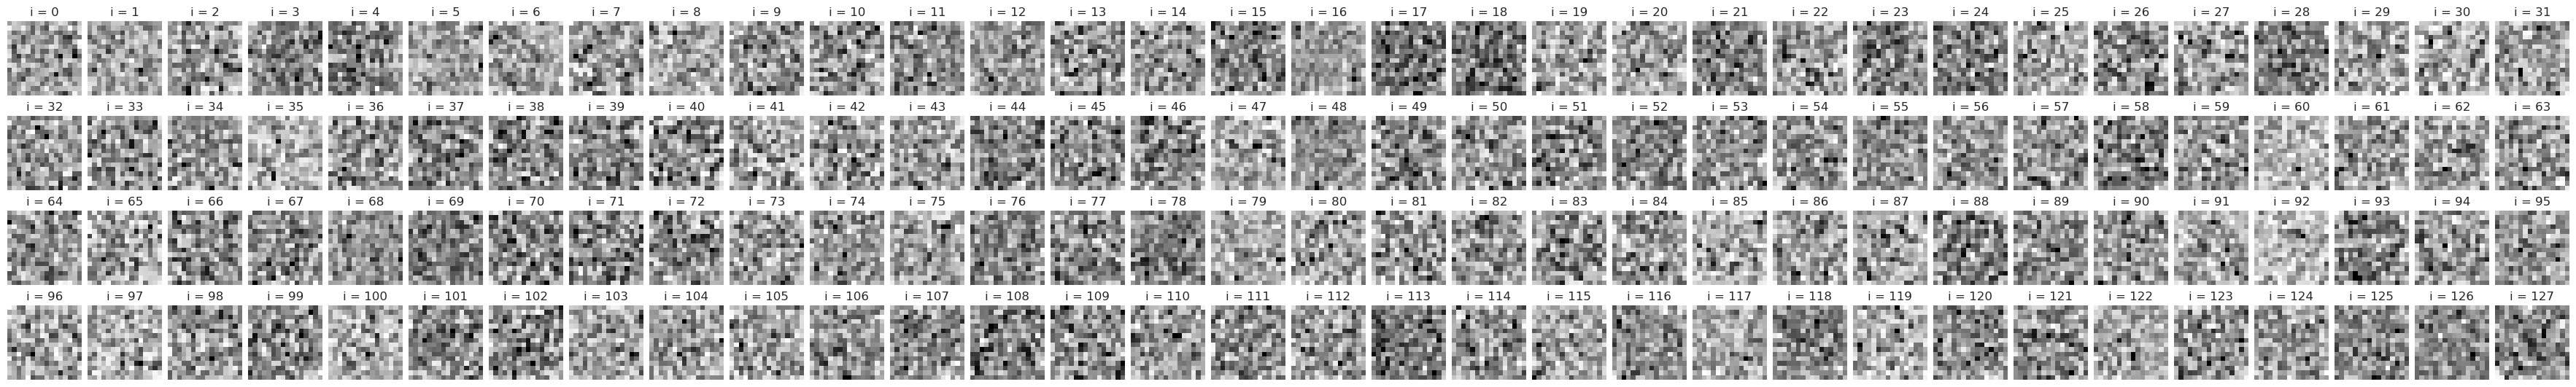

In [18]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')

for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    
    x2p = tonp(pred[sample_i])
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")

trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [19]:
sample_i = 30

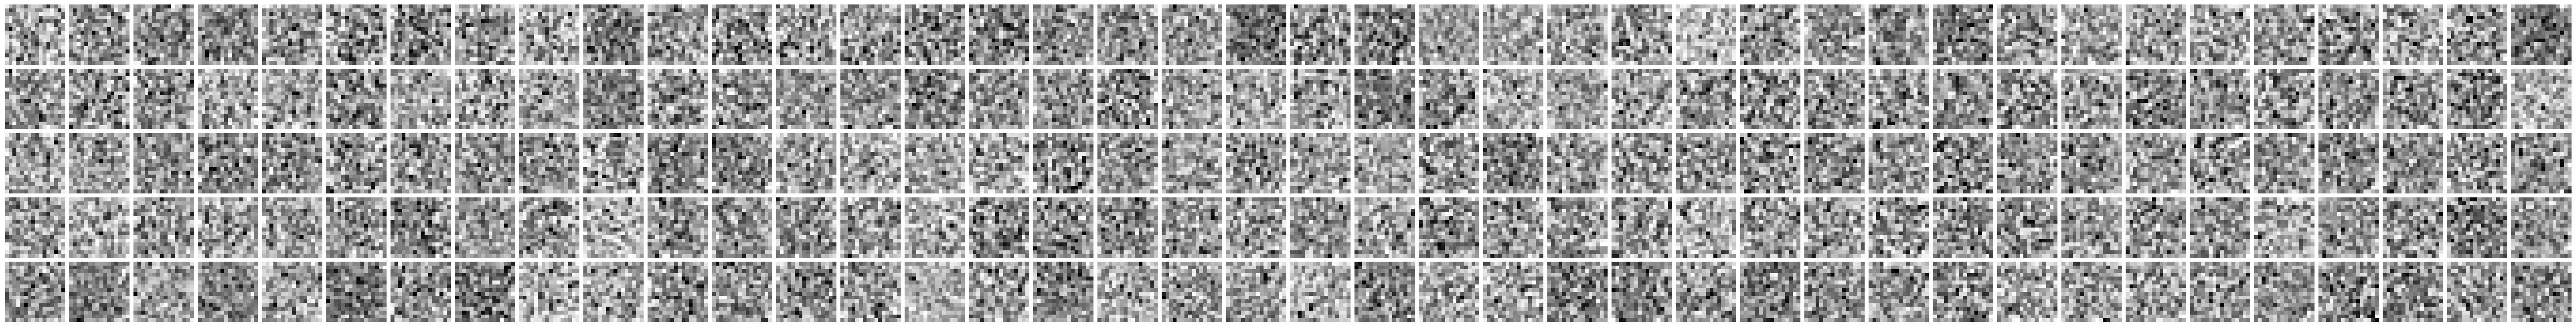

In [20]:
nrows, ncols = 5, 40
fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all')

for idx, ax in enumerate(axes.flat):
    i, j = idx // ncols, idx % ncols
    
    x2p = tonp(y[sample_i, idx])
    ax.imshow(x2p, cmap='Greys_r')

remove_ticks(axes)

In [21]:
order = np.argsort(desc_len)[::-1]

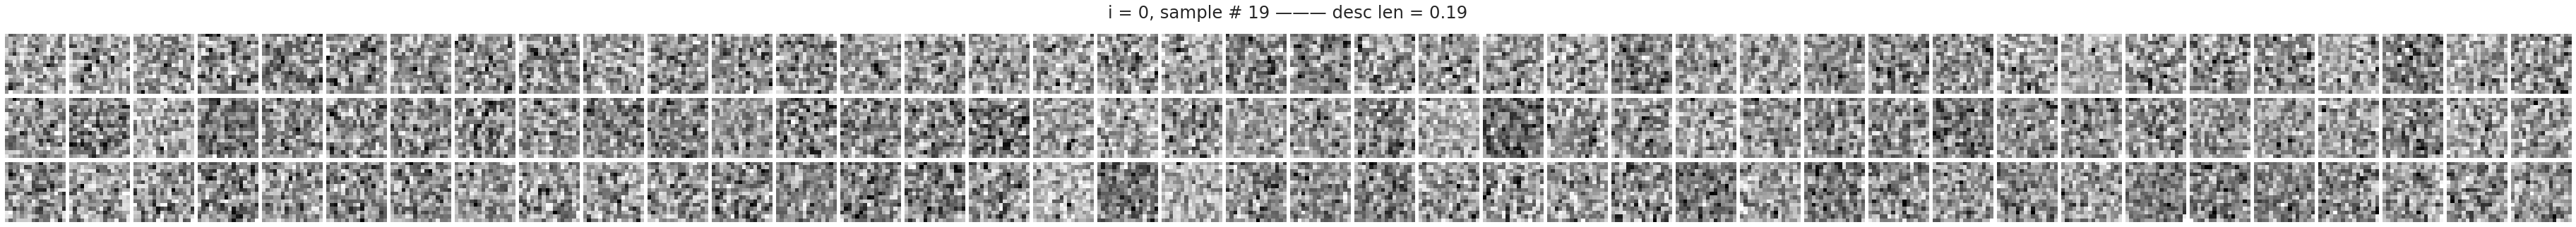

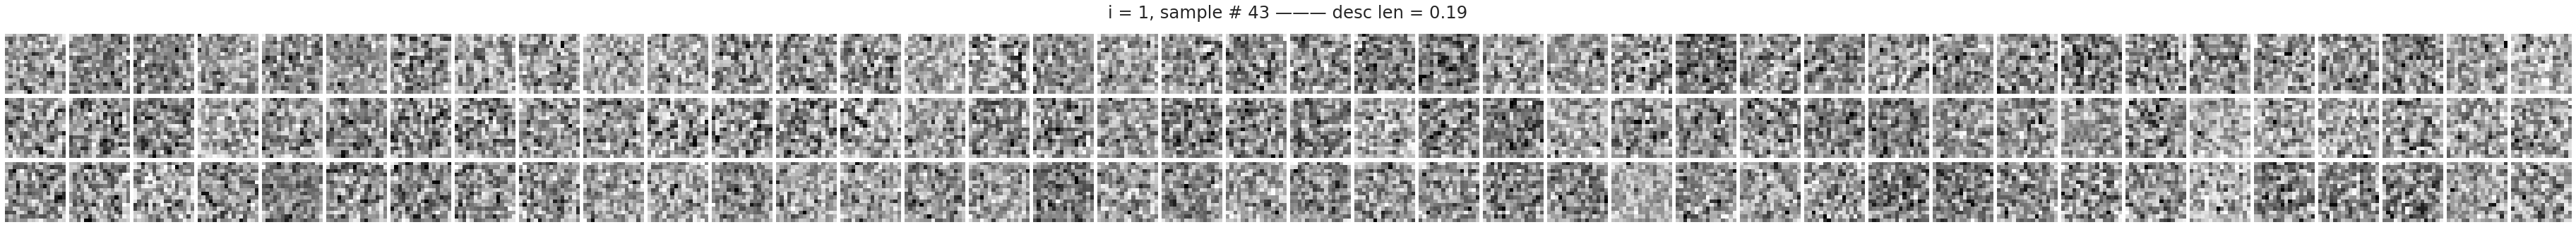

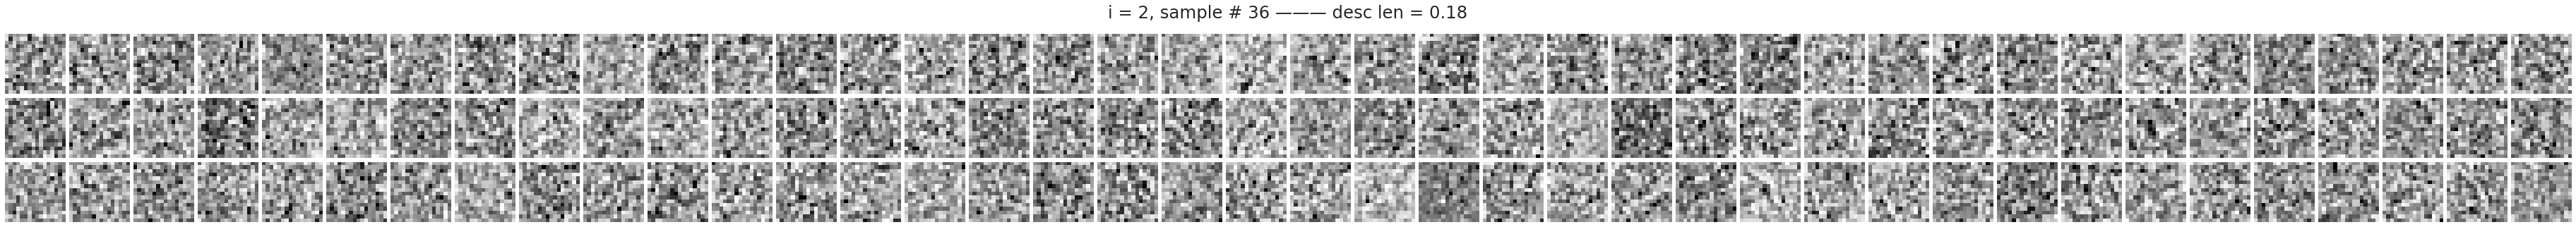

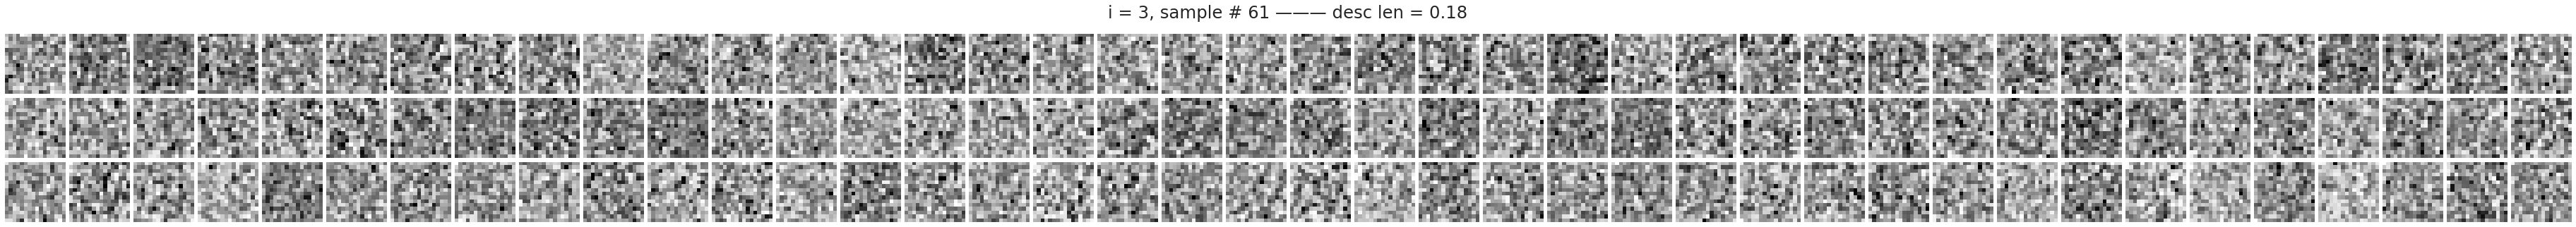

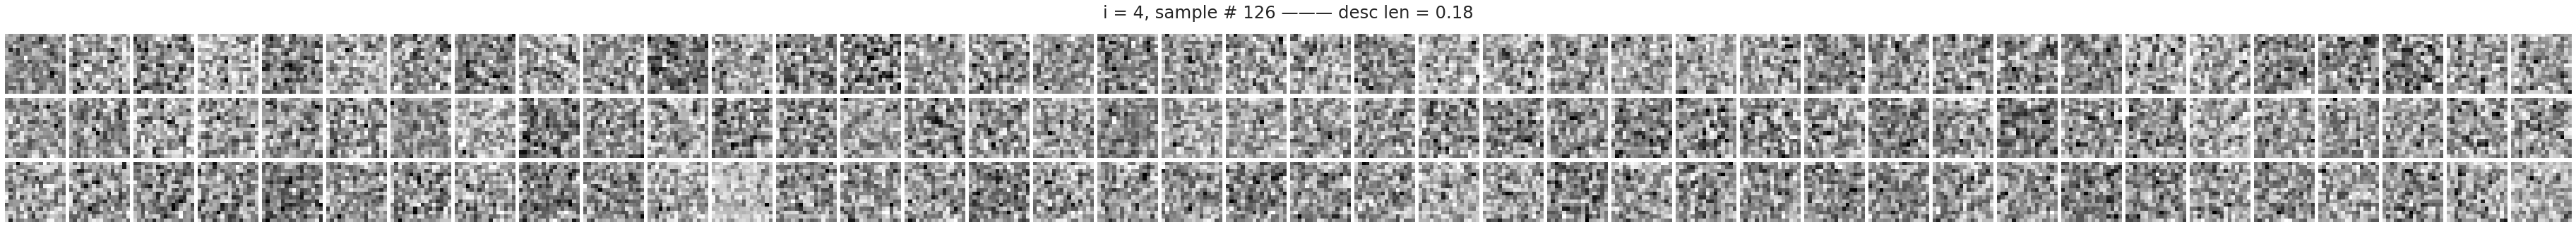

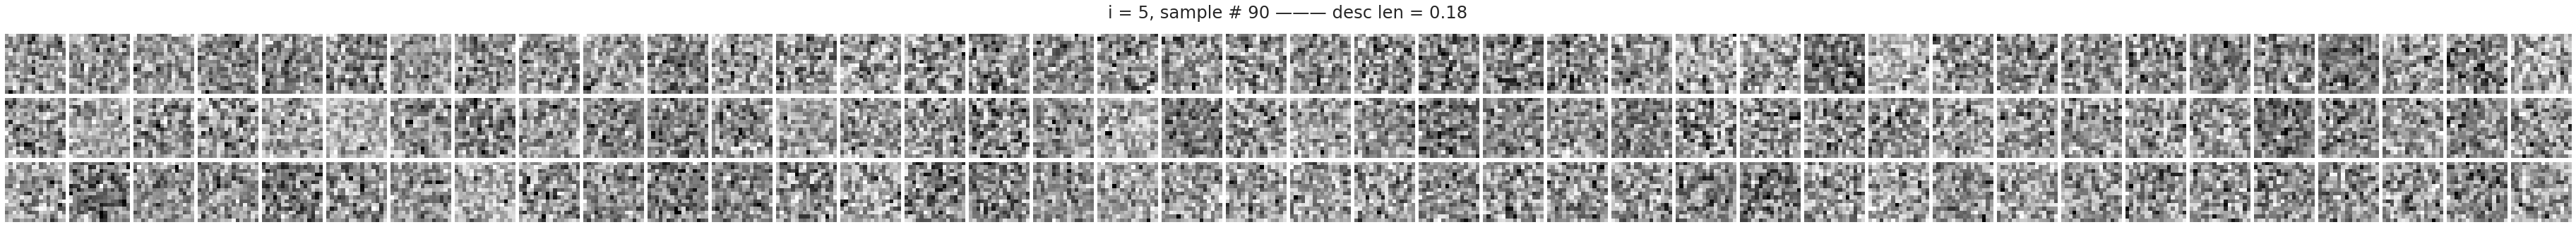

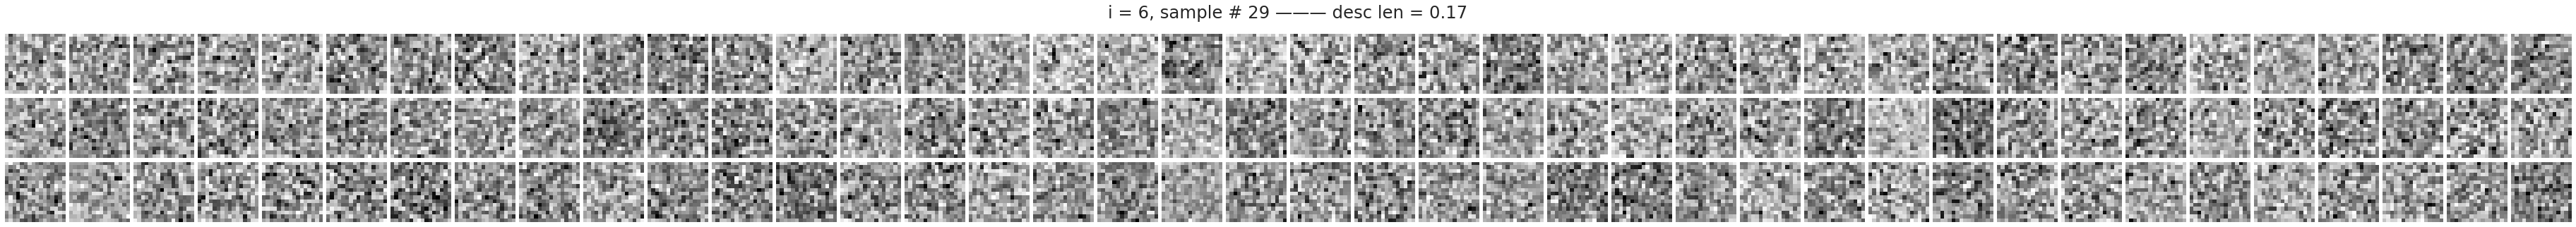

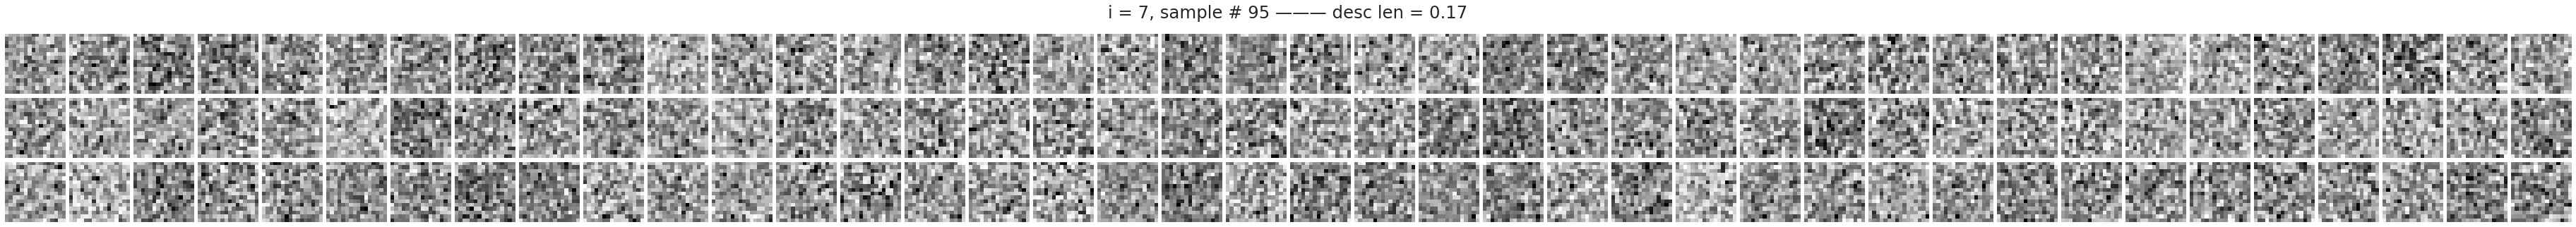

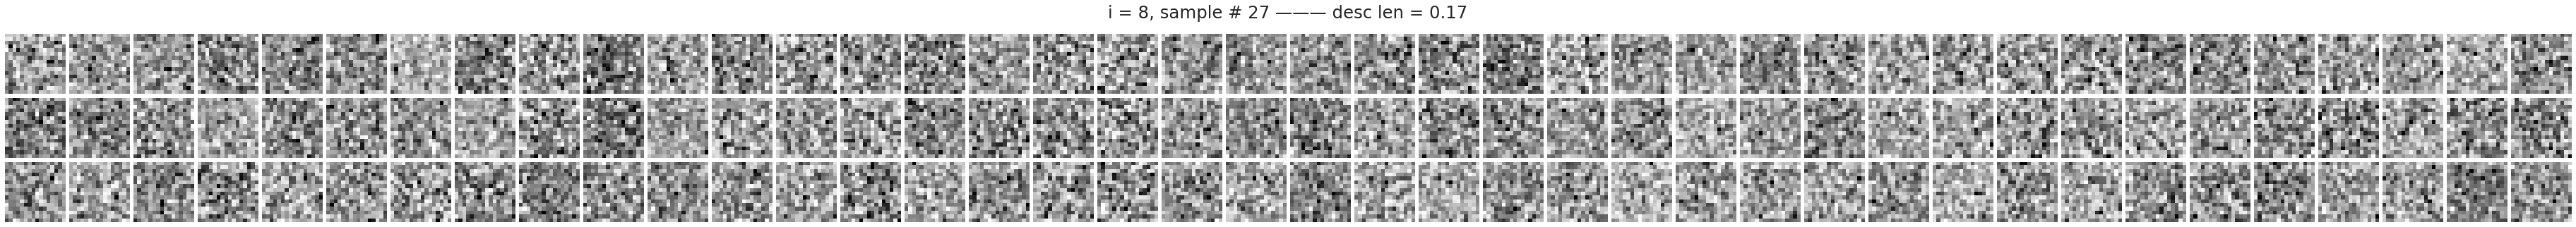

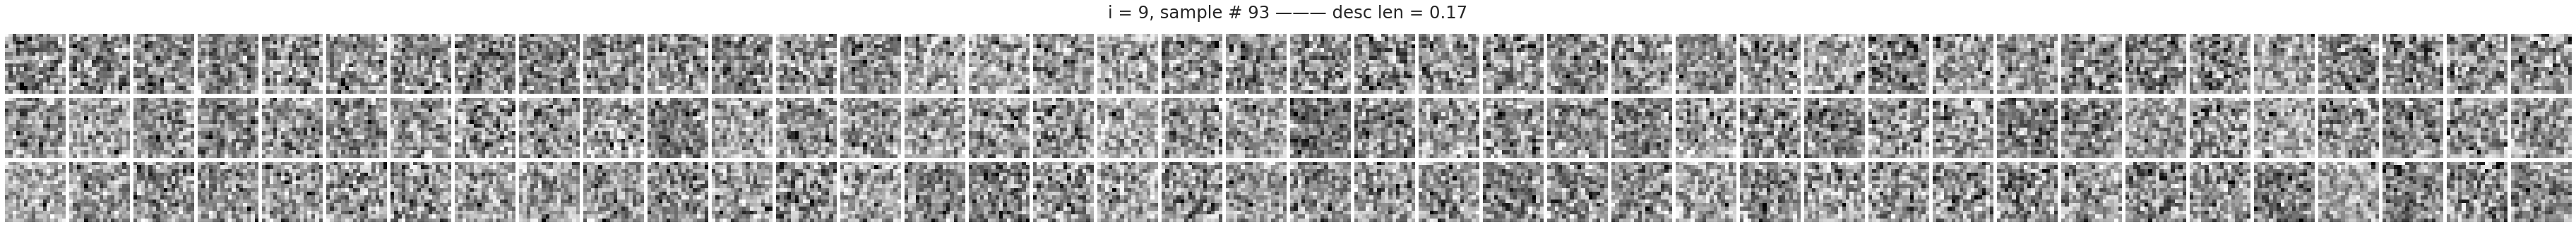

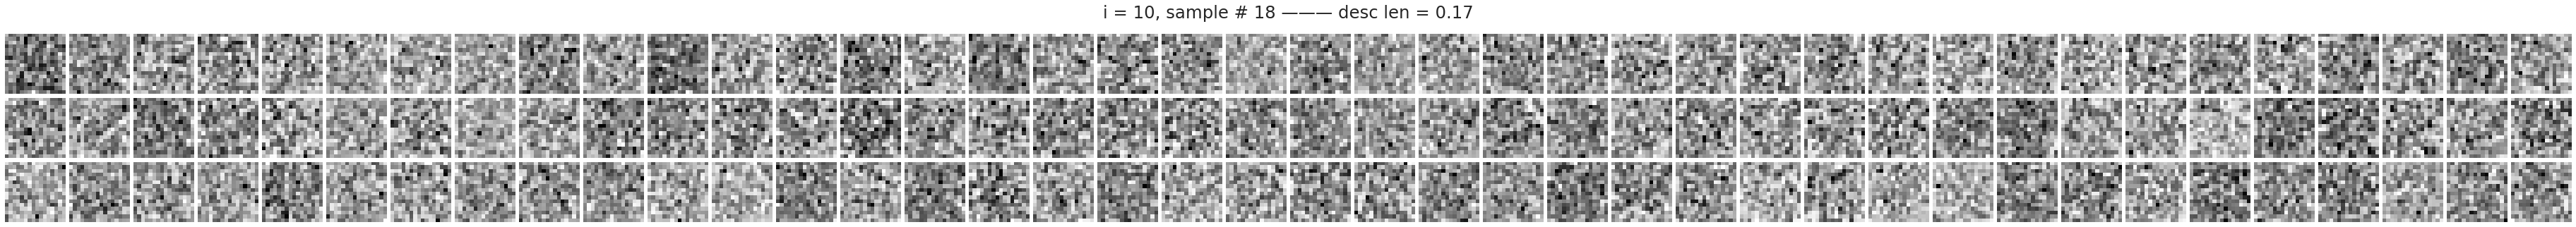

In [22]:
for i in range(len(pred)):
    if i > 10:
        continue
    sample_i = order[i]
    nrows, ncols = 3, 40
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=70)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i])
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(y[sample_i, idx - 1])
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()

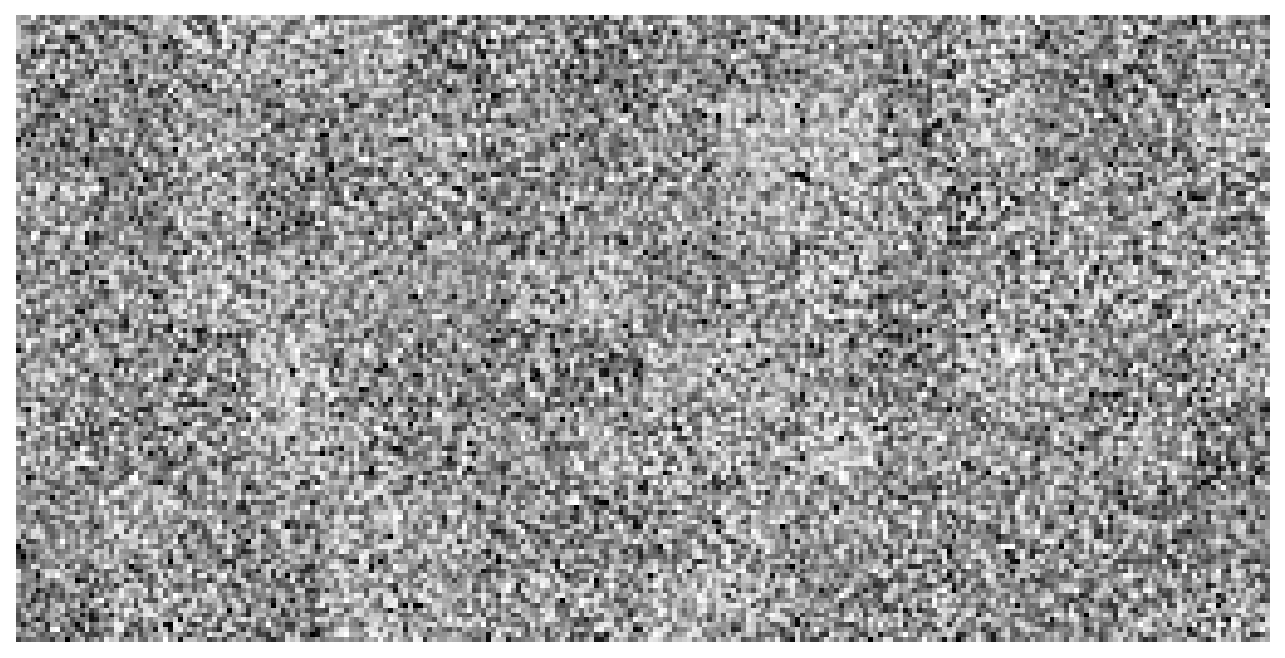

In [23]:
fig, ax = plot_weights(y[:, 80, ...], nrows=8, cmap='Greys', pad=0)
# fig.savefig(pjoin(fig_base_dir, 'generate-conv.pdf'), bbox_inches='tight')

## Older stuff

In [8]:
pois = output['dist']['T_9']
log_lambda = tonp(torch.log(pois.rate).ravel())

q = [0, 0.5, 0.75, 0.95, 1.0]  # np.arange(0, 1 + 1e-3, 0.2)
quantiles = np.quantile(log_lambda, q=q)

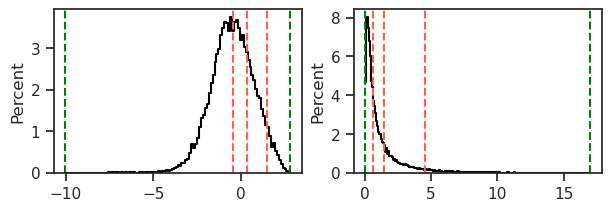

In [9]:
fig, axes = create_figure(1, 2)

sns.histplot(log_lambda, element='step', fill=False, stat='percent', label=k, color='k', ax=axes[0])
sns.histplot(np.exp(log_lambda), element='step', fill=False, stat='percent', label=k, color='k', ax=axes[1])

for i in range(len(quantiles)):
    color = 'g' if i in [0, len(quantiles) - 1] else 'tomato'
    axes[0].axvline(quantiles[i], ls='--', color=color)
    axes[1].axvline(np.exp(quantiles[i]), ls='--', color=color)

plt.show()

In [10]:
pois.rate.shape, pois.rsample().shape

(torch.Size([200, 128]), torch.Size([200, 128]))

In [ ]:
# pois = output['dist']['T_9']
# log_lambda = tonp(torch.log(pois.rate).ravel())

#   # np.arange(0, 1 + 1e-3, 0.2)
# quantiles = np.quantile(log_lambda, q=q)

In [60]:
quantiles = [0.5, 0.75, 0.95]
quantiles = [0] + quantiles + [1]
quantiles = sorted(set(quantiles))

print(quantiles)

[0, 0.5, 0.75, 0.95, 1]

In [61]:
masks = {}
for i in range(len(quantiles) - 1):
    lower = torch.quantile(pois.rate, quantiles[i])
    higher = torch.quantile(pois.rate, quantiles[i + 1])
    masks[i] = (lower < pois.rate) & (pois.rate <= higher)

print({i: m.float().mean() for i, m in masks.items()})

{
    0: tensor(0.5000, device='cuda:0'),
    1: tensor(0.2500, device='cuda:0'),
    2: tensor(0.2000, device='cuda:0'),
    3: tensor(0.0500, device='cuda:0')
}

In [62]:
from base.distributions import compute_n_exp

In [63]:
r_max = {i: pois.rate[m].max().item() for i, m in masks.items()}
n_exp = {i: compute_n_exp(r) for i, r in r_max.items()}
print(n_exp)

{0: 7, 1: 10, 2: 18, 3: 40}

In [64]:
tot = 0
for i, m in masks.items():
    tot += m.sum() * n_exp[i]

print(tot)

tensor(296953, device='cuda:0')

In [66]:
total_full = pois.rate.numel() * list(n_exp.values())[-1]
total_full

1024000

In [5]:
alphas = F.softplus(self.model.alphas_base)
alphas = F.normalize(alphas, p=1.0)
alphas.mul_(self.model.cfg.seq_len)

tensor([[5.2898e-08, 9.0127e-01, 6.6399e-01, 8.7520e-01, 9.7630e-01, 1.0571e+00,
         1.1890e+00, 1.3531e+00, 1.4134e+00, 1.5706e+00]], device='cuda:0',
       grad_fn=<MulBackward0>)

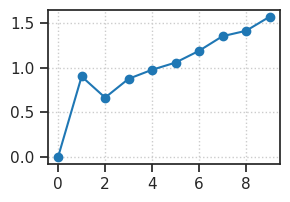

In [6]:
plt.plot(tonp(alphas.squeeze()), marker='o')
plt.grid()
plt.show()

In [7]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=100,
    n_data_batches=3,
    # active=~dead,
    full_data=True,
    # return_recon=False,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['vld'] # 'trn'] , 'tst']
}

100%|███████████████████████████████████| 3/3 [00:11<00:00,  3.80s/it]


CPU times: user 12.4 s, sys: 109 ms, total: 12.5 s
Wall time: 12.5 s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

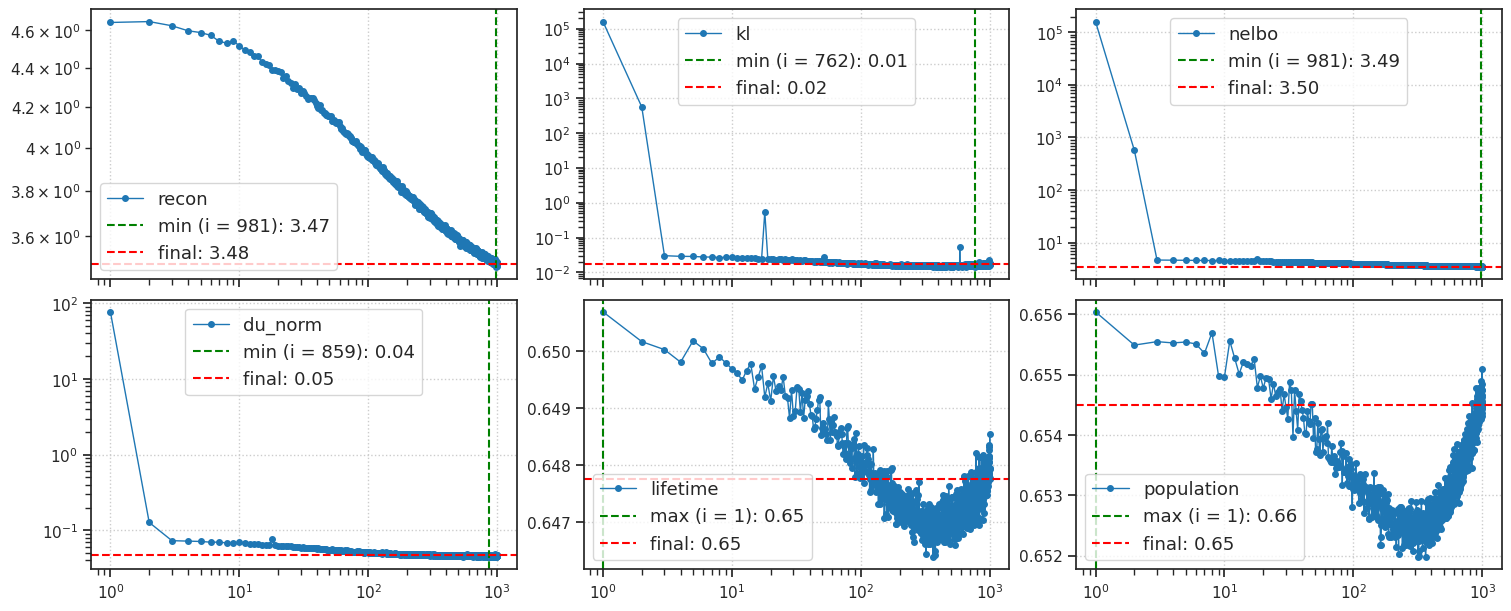

In [9]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

### Gaussian

In [ ]:
model_name = 'gaussian_MNIST_t-8_z-[2]_k-32_<conv+b|conv+b>'
fit_name = 'b200-ep500-lr(0.002)_beta(2:0x0.5)_gr(1000)_(2024_09_07,09:32)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

In [4]:
state = []
digits = []
for x, g in tqdm(iter(tr.dl_vld)):
    output = tr.model.xtract_ftr(x, return_state=True)
    state.append(output.stack('state'))
    digits.append(g)

state, digits = map(
    lambda e: tonp(torch.cat(e)),
    [state, digits],
)
state.shape, digits.shape

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 21.40it/s]


((10000, 8, 4), (10000,))

In [6]:
df = []
for t in range(tr.model.cfg.seq_len):
    df.append({
        'time': [t] * len(digits),
        'sample_i': range(len(digits)),
        'mu_0': state[:, t, 0],
        'mu_1': state[:, t, 1],
        'log_sigma_0': state[:, t, 2],
        'log_sigma_1': state[:, t, 3],
        'digits': digits,
    })
df = pd.DataFrame(merge_dicts(df))

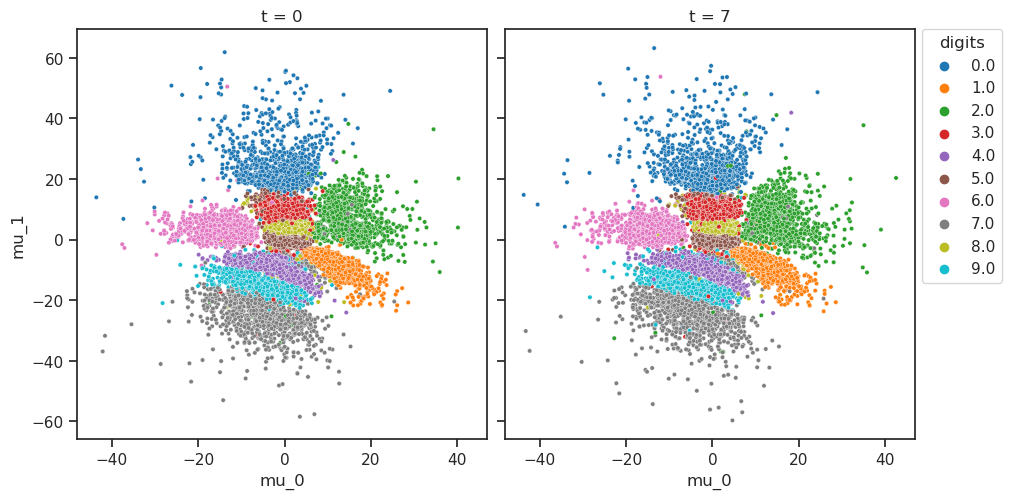

In [21]:
fig, axes = create_figure(1, 2, (10, 5), 'all', 'all')
for i, t in enumerate([0, 7]):
    ax = axes[i]
    sns.scatterplot(
        data=df.loc[df['time'] == t],
        x='mu_0',
        y='mu_1',
        hue='digits',
        palette='tab10',
        s=10,
        ax=ax,
    )
    ax.set_title(f"t = {t}")
move_legend(axes[0], None)
move_legend(axes[1], [1, 1.02])
ax_square(axes)
plt.show()

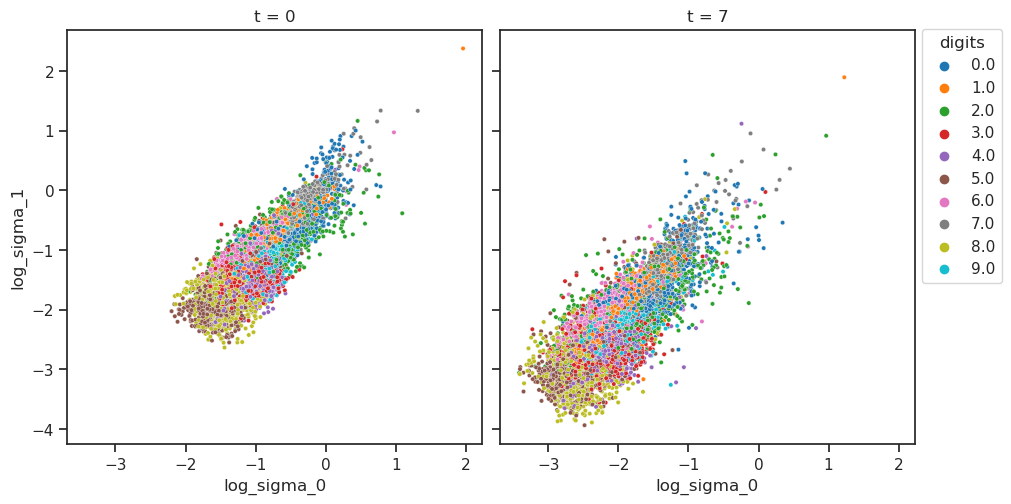

In [22]:
fig, axes = create_figure(1, 2, (10, 5), 'all', 'all')
for i, t in enumerate([0, 7]):
    ax = axes[i]
    sns.scatterplot(
        data=df.loc[df['time'] == t],
        x='log_sigma_0',
        y='log_sigma_1',
        hue='digits',
        palette='tab10',
        s=10,
        ax=ax,
    )
    ax.set_title(f"t = {t}")
move_legend(axes[0], None)
move_legend(axes[1], [1, 1.02])
ax_square(axes)
plt.show()

In [13]:
sample_i = 123
x = state[sample_i]

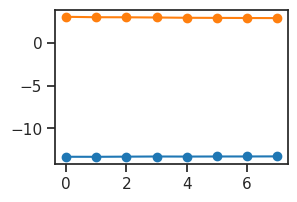

In [18]:
plt.plot(x[:, 0], marker='o')
plt.plot(x[:, 1], marker='o');

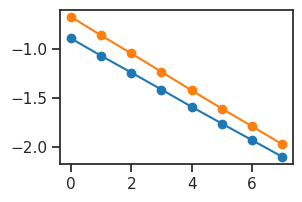

In [19]:
plt.plot(x[:, 2], marker='o')
plt.plot(x[:, 3], marker='o');

In [20]:
x[:, 1]

array([3.1016874, 3.0529828, 3.0453413, 3.0202985, 2.987599 , 2.9739113,
       2.9604445, 2.9493186], dtype=float32)

In [ ]:
"""log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()"""

In [7]:
loc = tonp(tr.model.layer.loc).ravel()
log_scale = tonp(tr.model.layer.log_scale).ravel()
bias = tonp(tr.model.layer.bias).ravel()

loc, log_scale, bias

(array([-0.0001107,  0.0277274], dtype=float32),
 array([2.2106938, 2.5960941], dtype=float32),
 array([-0.00737888,  0.00678796, -0.08695927, -0.08957231], dtype=float32))

In [8]:
dead = loc > 2
dead.sum()

0

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

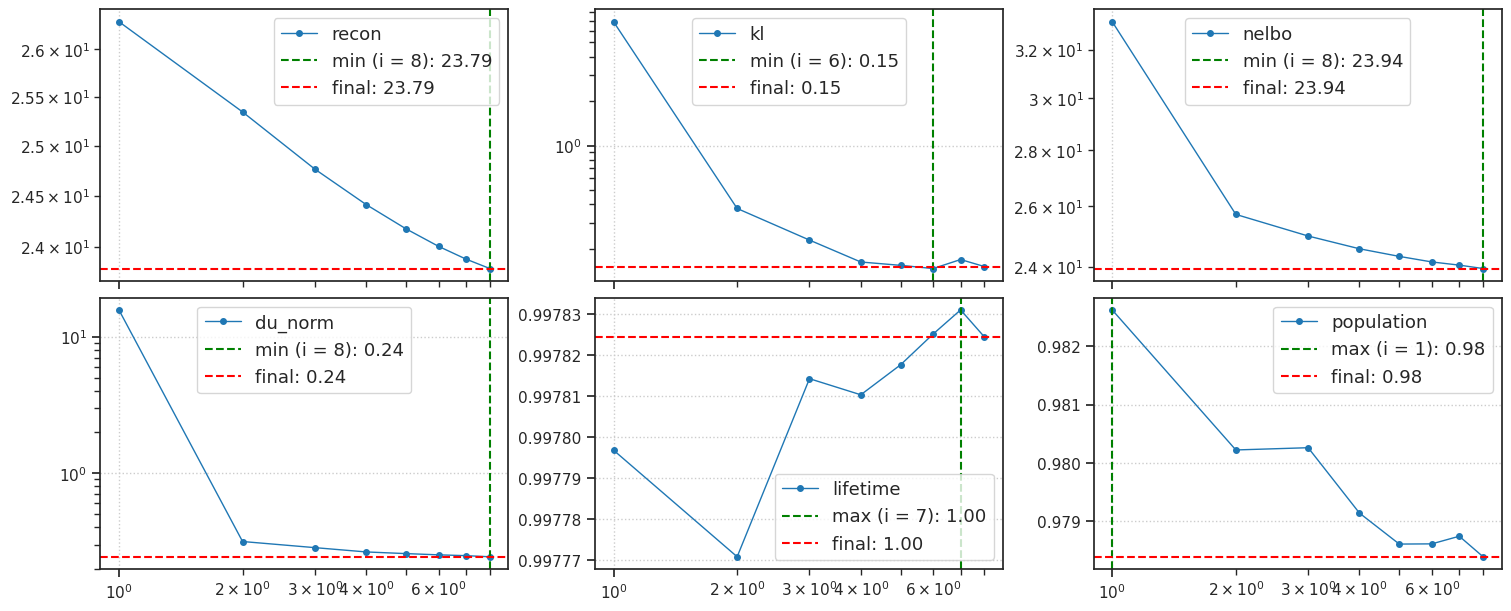

In [7]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

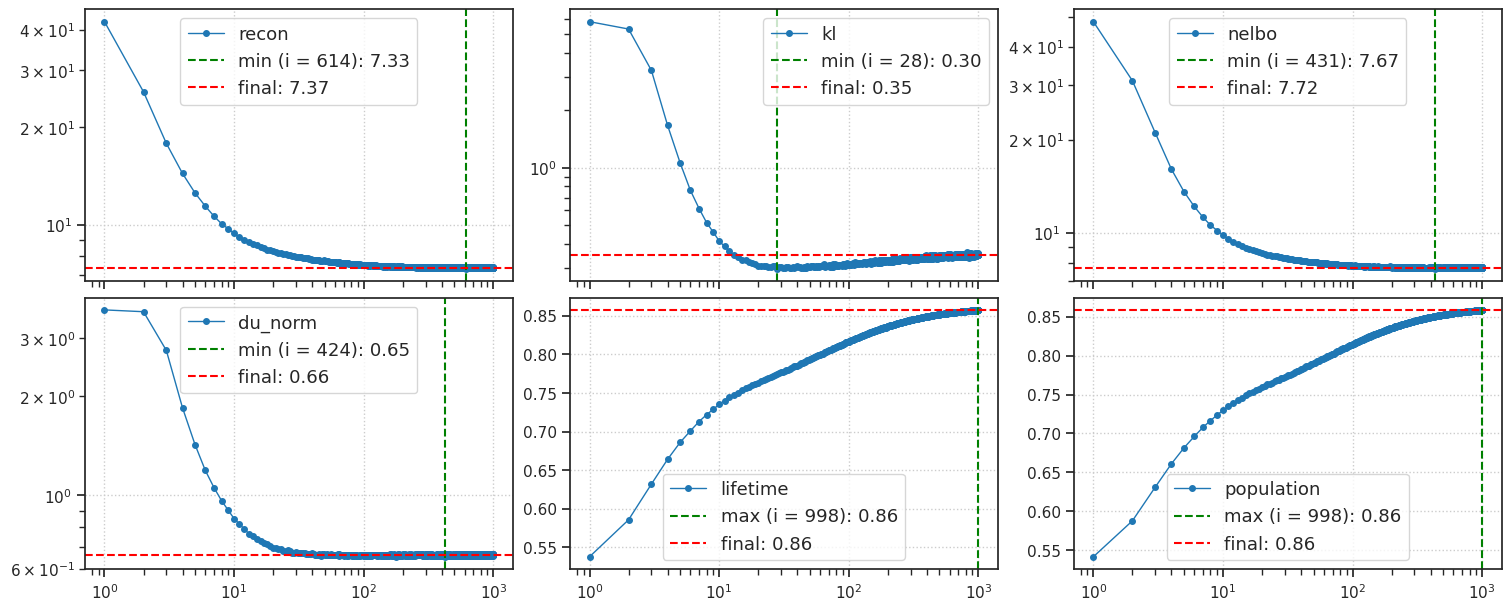

In [16]:
## was:  < jacob | mlp+b > (gold standard)

In [8]:
state = results['vld']['state_final']
digits = results['vld']['g'].astype(int)

df2p = {
    'mu_0': state[:, 0],
    'mu_1': state[:, 1],
    'log_sigma_0': state[:, 2],
    'log_sigma_1': state[:, 3],
    'digits': digits,
}
df2p = pd.DataFrame(df2p)

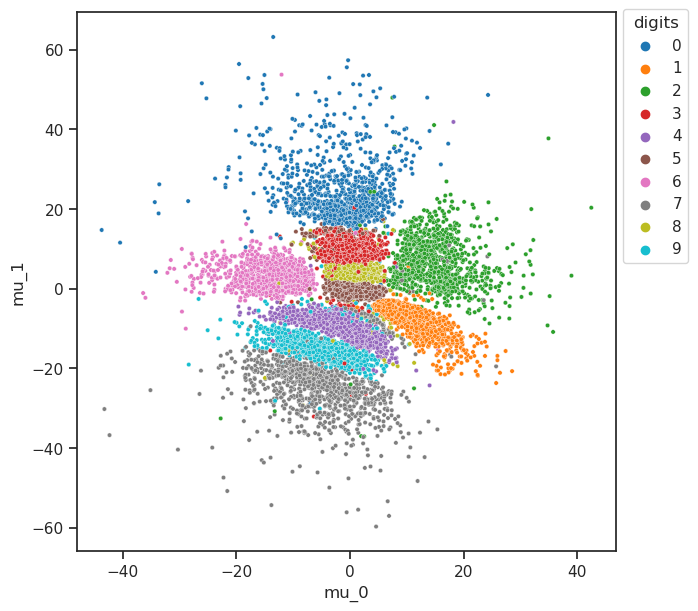

In [9]:
fig, ax = create_figure(1, 1, (7, 6))
sns.scatterplot(
    data=df2p,
    x='mu_0',
    y='mu_1',
    hue='digits',
    palette='tab10',
    s=10,
    ax=ax,
)
move_legend(ax, [1, 1.02])
ax_square(ax)
plt.show()

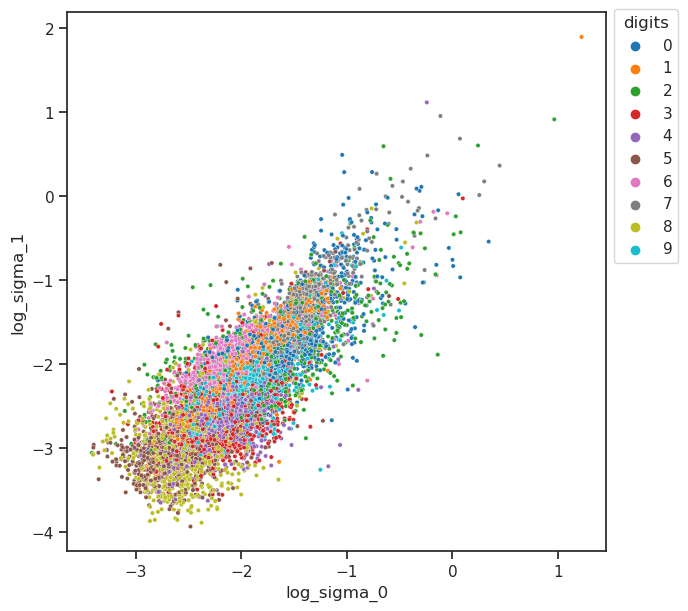

In [10]:
fig, ax = create_figure(1, 1, (7, 6))
sns.scatterplot(
    data=df2p,
    x='log_sigma_0',
    y='log_sigma_1',
    hue='digits',
    palette='tab10',
    s=10,
    ax=ax,
)
move_legend(ax, [1, 1.02])
ax_square(ax)
plt.show()

### Generate

In [18]:
n_samples = 64
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)
pred = tr.model.pred

output = tr.model.generate(pred, seq=range(300))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['ff', 'dist', 'samples', 'recon', 'loss_kl', 'loss_recon']

In [19]:
shape = (tr.model.cfg.input_sz, tr.model.cfg.input_sz)

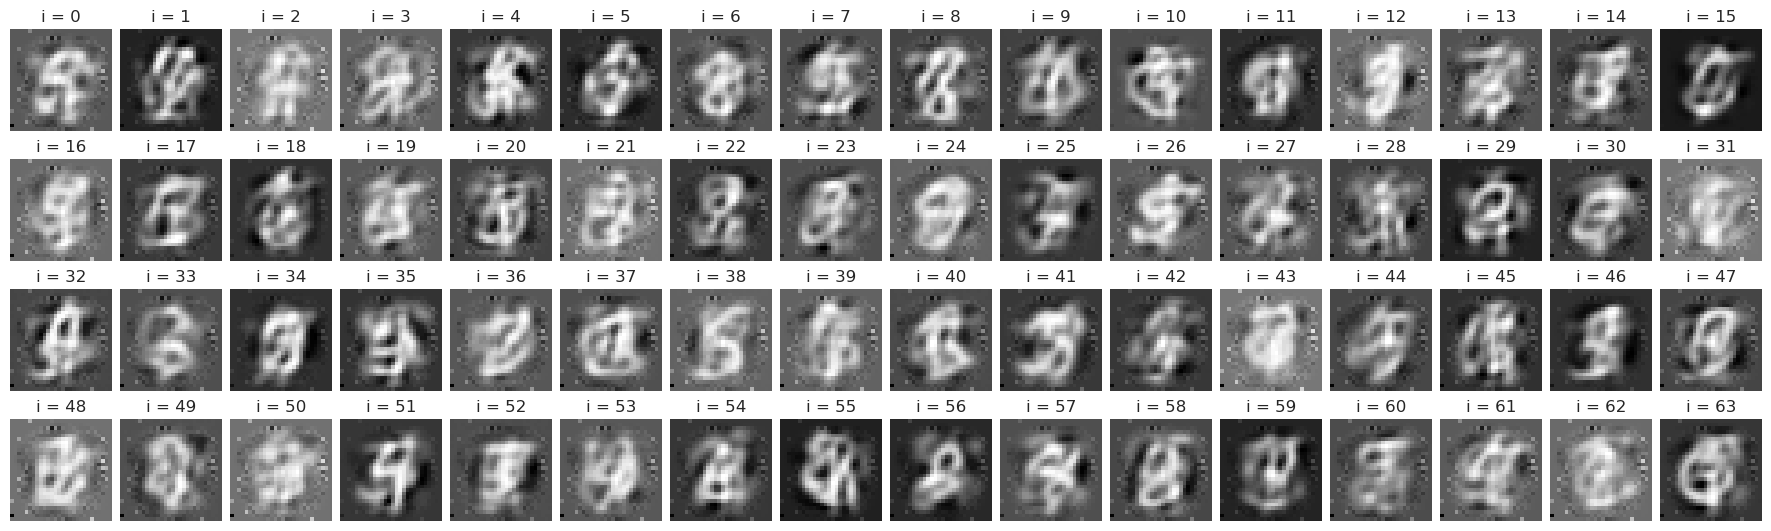

In [20]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')
for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    x2p = tonp(pred[sample_i].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")
trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [21]:
sample_i = 30

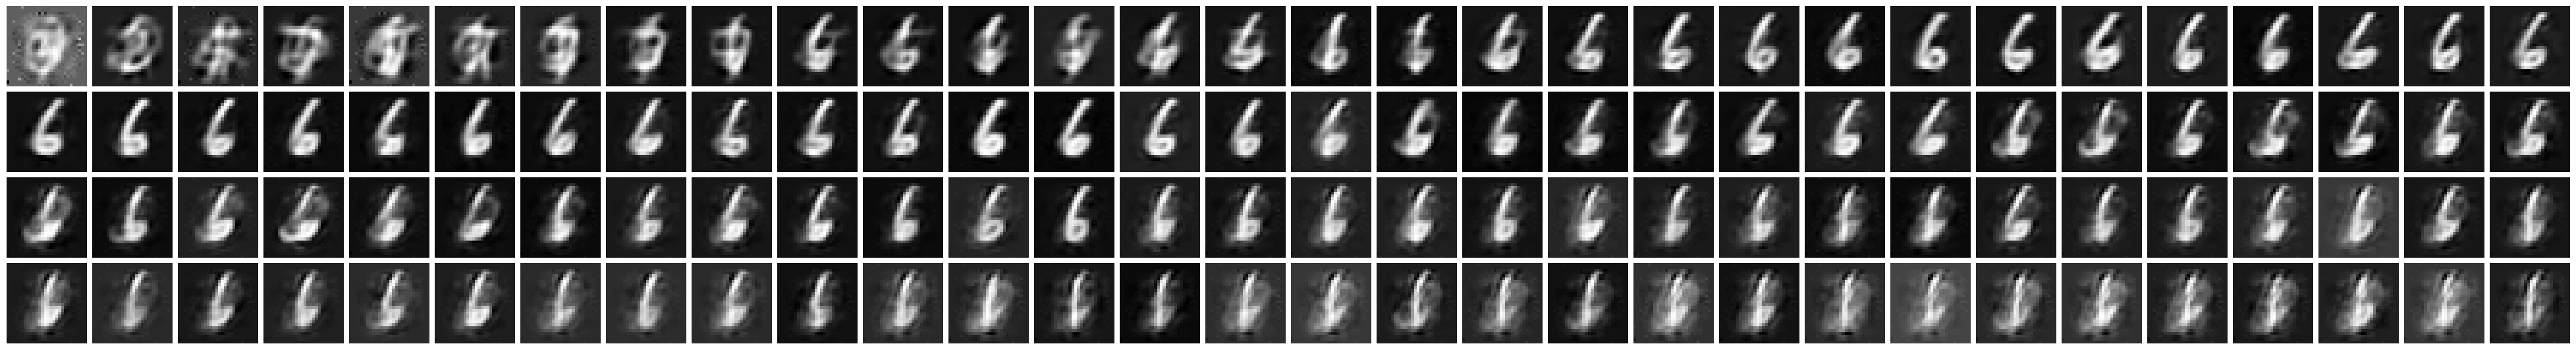

In [22]:
nrows, ncols = 4, 30
fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all')
for idx, ax in enumerate(axes.flat):
    i, j = idx // ncols, idx % ncols
    x2p = tonp(output['recon'][sample_i, idx].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
remove_ticks(axes)

In [25]:
order = np.argsort(desc_len)[::-1]

### Gaussian

In [3]:
which = 'mlp'

paste here:


In [10]:
if which == 'conv':
    model_name = ''
    fit_name = ''

elif which == 'mlp':
    model_name = 'gaussian_MNIST_t-10_z-[128]_k-32_<jacob|mlp+b>'
    fit_name = 'b200-ep500-lr(0.002)_beta(5:0x0.5)_gr(1000)_(2024_09_06,20:37)'

elif which == 'lin':
    model_name = ''
    fit_name = ''

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

500

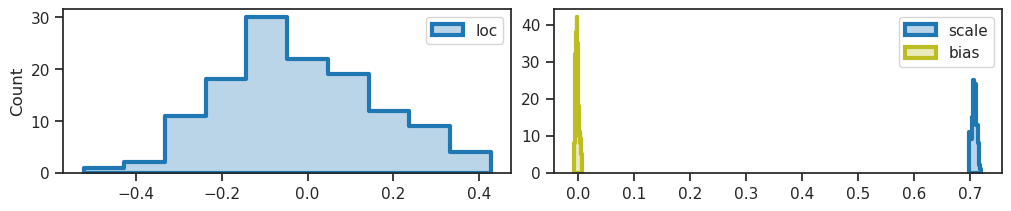

In [9]:
loc = tonp(tr.model.layer.loc).ravel()
log_scale = tonp(tr.model.layer.log_scale).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(loc, color='C0', element='step', label='loc', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_scale), color='C0', element='step', label='scale', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [6]:
dead = loc > 2
dead.sum()

0

In [7]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=3,
    active=~dead,
    # full_data=True,
    # return_recon=False,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['vld'] # 'trn'] , 'tst']
}

100%|███████████████████████████████████| 3/3 [00:08<00:00,  2.96s/it]


CPU times: user 8.22 s, sys: 460 ms, total: 8.68 s
Wall time: 9.77 s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

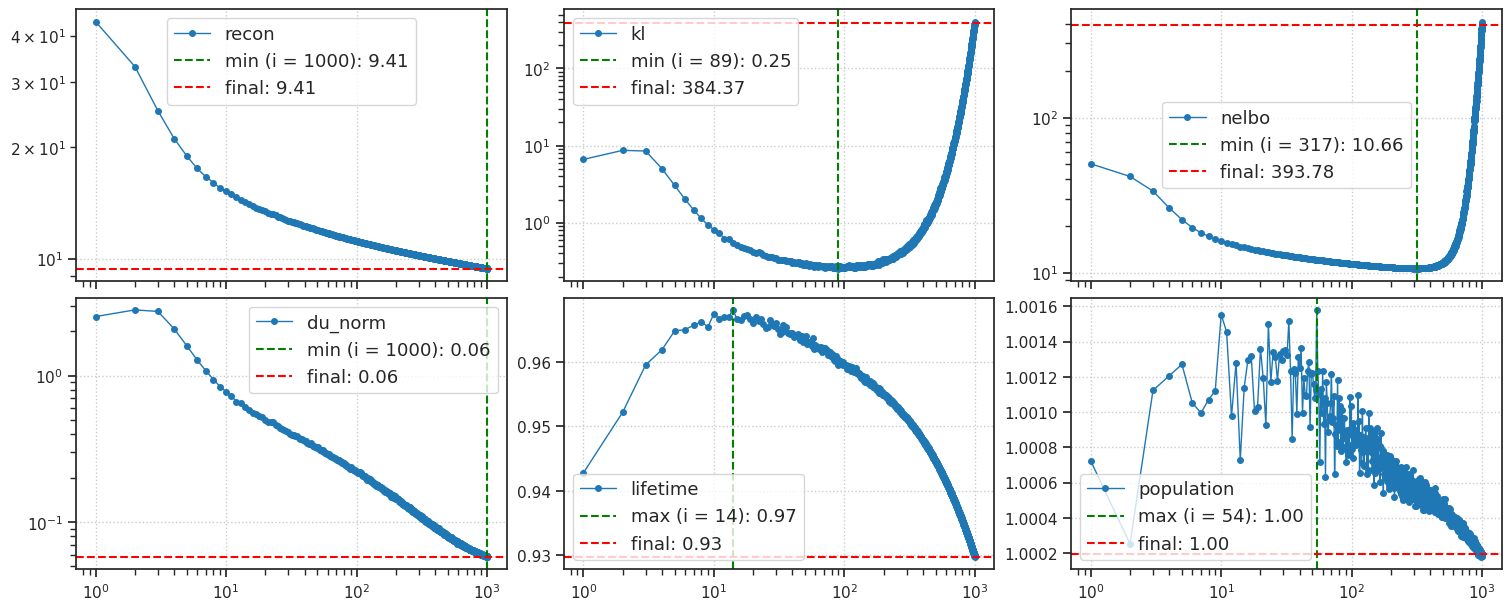

In [8]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

### Poisson MLP

Gold standard

In [3]:
which = 'mlp'

paste here:


In [4]:
if which == 'conv':
    model_name = 'poisson_uniform_c(-2)_MNIST_t-16_z-[128]_k-32_<jacob|conv+b>'
    fit_name = 'mc_b256-ep600-lr(0.002)_beta(4:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_09_06,00:50)'

elif which == 'mlp':
    model_name = 'poisson_uniform_c(-2)_MNIST_t-10_z-[128]_k-32_<jacob|mlp+b>'
    fit_name = 'FINAL_b200-ep500-lr(0.002)_beta(5:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_09_06,19:15)'

elif which == 'lin':
    model_name = ''
    fit_name = ''

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

500

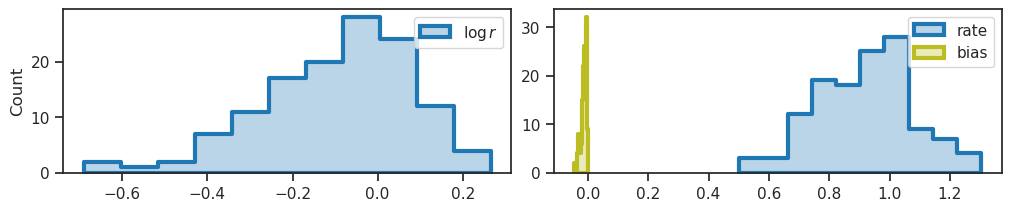

In [5]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [6]:
dead = log_rate > 2
dead.sum()

0

In [7]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=0,
    active=~dead,
    # full_data=True,
    # return_recon=False,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['vld'] # 'trn'] , 'tst']
}

100%|█████████████████████████████████| 50/50 [01:26<00:00,  1.73s/it]


CPU times: user 1min 26s, sys: 2.19 s, total: 1min 28s
Wall time: 1min 28s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

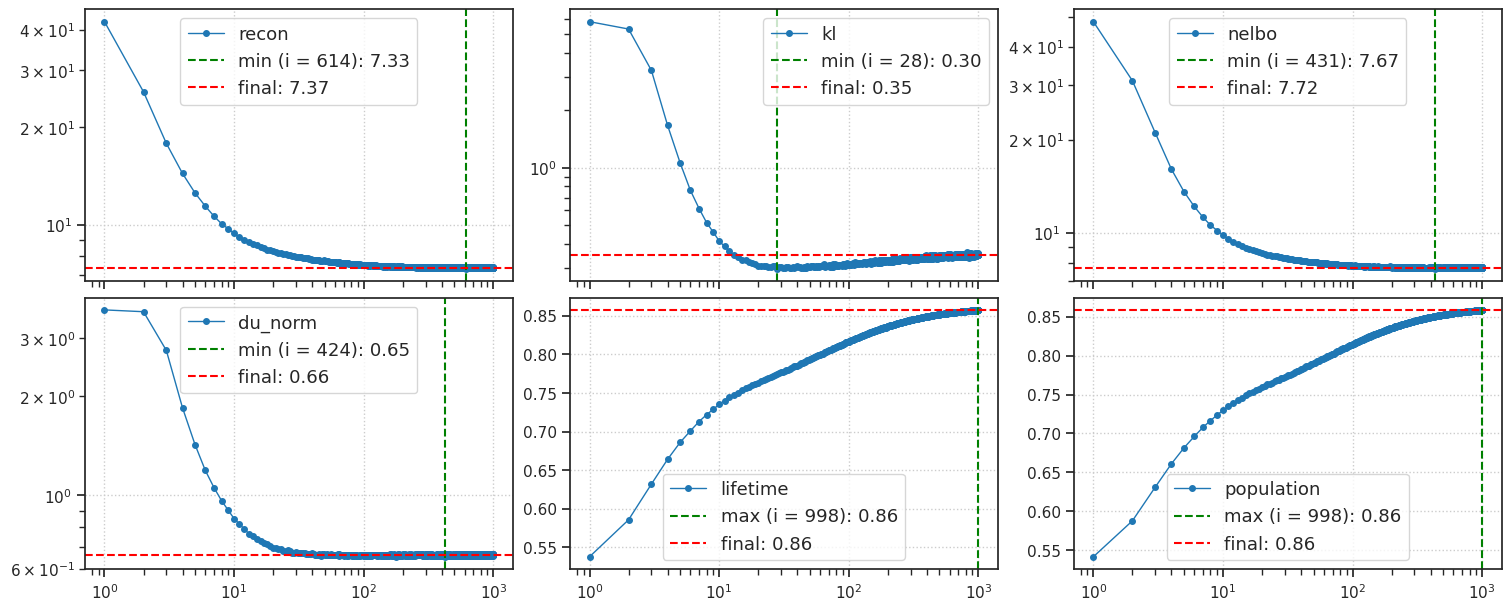

In [8]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

In [35]:
kl_temporal = []
kl_one_shot = []

with torch.no_grad():
    for x, *_ in tqdm(iter(tr.dl_vld)):
        output = tr.model.xtract_ftr(x)
        output = output.stack()
        
        kl_temporal.append(torch.sum(output['loss_kl'], dim=2))
        
        prior = tr.model.layer.log_rate.expand((len(x), -1))
        kl_one_shot.append(torch.sum(tr.model.layer.loss_kl(
            u=prior, du=tr.model.state - prior), dim=1))

    kl_temporal = torch.cat(kl_temporal)
    kl_one_shot = torch.cat(kl_one_shot)

kl_temporal.shape, kl_one_shot.shape

100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 80.38it/s]


(torch.Size([10000, 10]), torch.Size([10000]))

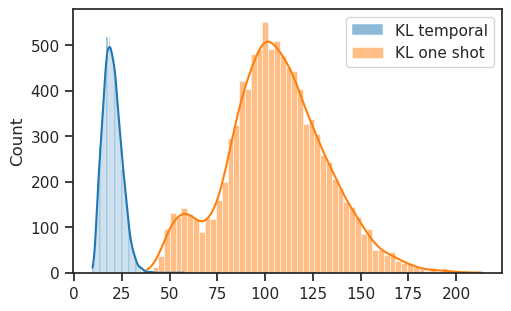

In [36]:
fig, ax = create_figure(1, 1, (5, 3))
sns.histplot(tonp(kl_temporal.sum(1)), kde=True, label='KL temporal')
sns.histplot(tonp(kl_one_shot), kde=True, label='KL one shot')
ax.legend()
plt.show()